<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-the-results" data-toc-modified-id="Load-the-results-1">Load the results</a></span></li></ul></div>

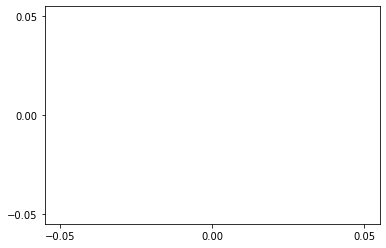

In [1]:
import torch
import seaborn as sns
from src.models import PJPE
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from src.viz.mpl_plots import plot_superimposition, plot_2d, plot_3d
from src.trainer import project_3d_to_2d
%load_ext autoreload
%autoreload 2

### Load the results

In [3]:
# Get metrics

resume = "absurd-music-3244"
mj = 0
t_data_bh = torch.load(f"../src/results/t_data_{resume}_bh_True_mj_{mj}.pt")
t_data_zv = torch.load(f"../src/results/t_data_{resume}_bh_False_mj_{mj}.pt")

pjpe_bh = t_data_bh['bh']
pjpe_zv = t_data_zv['zv']
print(list(t_data_zv.keys()))

['recon_2d', 'recon_3d', 'novel_2d', 'target_2d', 'target_3d', 'z', 'action', 'recon_3d_org', 'zv']


In [ ]:
# Get data
pjpes = pjpe_bh.cpu().numpy()
actions = t_data_bh['action'].cpu().numpy()

ax = sns.violinplot(actions, pjpes)

ticks = list(np.arange(100, pjpes.max()+50, 50))
ticks.extend(np.arange(0,100,20))
_ = plt.setp(ax,yticks=sorted(ticks))
_ = ax.set_xticklabels(["Directions", "Discussion", "Eating", "Greeting", "Phoning", "Photo", "Posing", "Purchases",
                             "Sitting", "SittingDown", "Smoking", "Waiting", "WalkDog", "Walking", "WalkTogether"])
_ = plt.savefig("../src/results/violin_pjpe.svg", format='svg', dpi=1200)

In [ ]:
selections = []
pjpes = pjpe_zv.cpu().numpy()

for a in range(2,17):
    ids_a = np.where(actions==a)
    mean_a = pjpes[ids_a].mean()
    id_close = np.abs(pjpes[ids_a] - mean_a).argmin()
    id = np.where(pjpes == pjpes[ids_a][id_close])
    selections.append(id)
    print(id, pjpes[ids_a][id_close])

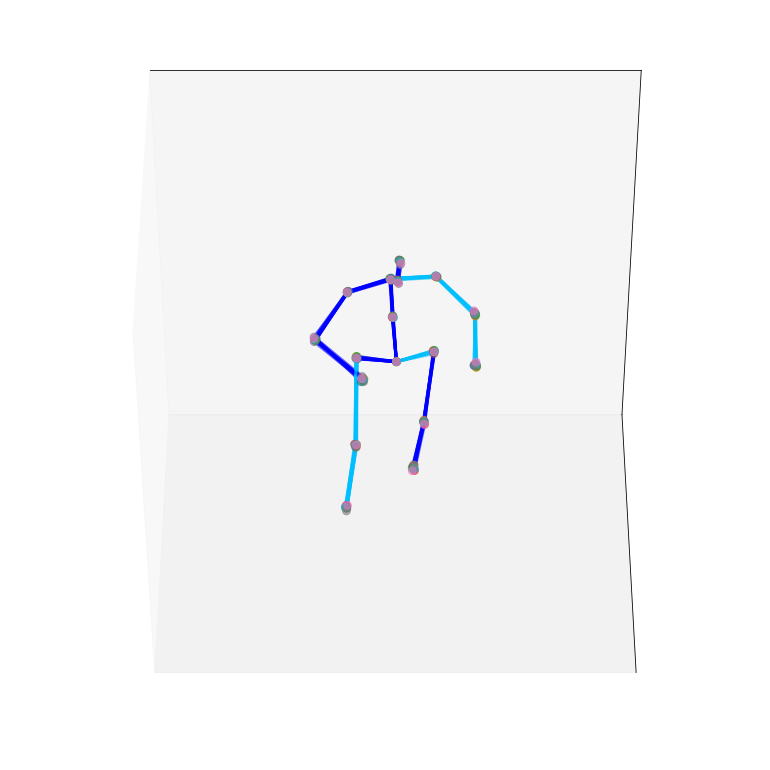

In [23]:
n_recons = torch.stack(t_data_bh['n_recons'])

idx = 200
for i in range(10):
    pose_3d = n_recons[i, idx, Ellipsis]
#     pose_3d_z = pose_3d[Ellipsis, -1] + 1e-15
#     pose_2d = pose_3d[Ellipsis, 0:2]/pose_3d_z.view(17,1)
#     plot_2d(pose_2d, mode='show', show_ticks=True, labels=True, background=None)
    _ = plot_3d(pose_3d.numpy(), mode='axis')
    

In [ ]:
t_data_zv['recon_3d'].shape